## Formulation
Lets say you have two vector valued random variables $x$ and $y$ with some joint density $p(x,y)$.  Assume you can generate samples of $(x,y)$.

Let $r_i^{(k)}$ denote component $i$ of the random variable $r$ in layer $k$ of the normalizing flow.   Using a RealNVP approach, each layer of the transformation takes the form
$$
\left[\begin{array}{c}r_{0:d}^{(k+1)}\\ r_{d+1:D}^{(k+1)} \end{array}\right] = P\left[\begin{array}{c}r_{0:d}^{(k)}\\ b\left(r_{0:d}^{(k)}\right) + s\left(r_{0:d}^{(k)}\right)r_{d+1:D}^{(k)} \end{array}\right],
$$
where $P$ is a permutation matrix.

In [1]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import sys
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp

from Models.NVP import NVP
from Probability.Distributions import RotatedBanana
from Probability.MCMC import MH2d

tfd = tfp.distributions
tfb = tfp.bijectors

## Train the Normalizing Flow
First, we train the flow to map a double banana distribution to a guassian. The end goal is to perform conditional sampling using MCMC along a part of the distribution where we cross 2 different 'modes'. 

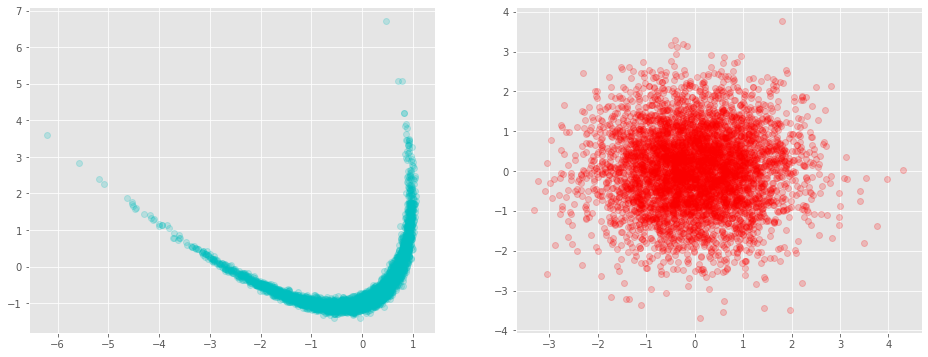

In [2]:
# Distrubtion that we want to learn to map to gaussian 
num_samples = 5000

target_2d = RotatedBanana(num_samples, 25.0, start_height = -1)
noise = tf.random.normal([num_samples],mean=0.0,stddev=0.001)
#tgt_y = tgt_x**2 + tf.random.normal([num_samples],mean=0.0,stddev=0.5)
target_3d = tf.stack([target_2d[:,1], target_2d[:,0], target_2d[:,1]+noise], axis=1)

latent = tf.random.normal([num_samples,3],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target_3d[:,1], target_3d[:,0], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2)

### Define an NVP-based normalizing flow

In [3]:
# Create model object
nvp = NVP(num_masked=2, output_dim=3, num_layers=5, neuron_list=[100,100], permutations=[[0,2,1]]*9)

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=5e-4, epsilon=1e-06)
nvp.compile(opt)

# Perform a forward pass to initialize variables
_ = nvp(latent)

### Print a summary of the model

In [4]:
nvp.summary()

Model: "NVP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 53,034
Trainable params: 53,034
Non-trainable params: 0
_________________________________________________________________


### Train the model using ADAM

In [5]:
# Define training options
n_epochs = 400
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target_3d)
dataset = dataset.shuffle(buffer_size=5000).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/400
100/100 [==============================] - 2s 23ms/step - Negative Log Likelihood: 0.2456
Epoch 2/400
100/100 [==============================] - 2s 23ms/step - Negative Log Likelihood: -1.6792
Epoch 3/400
100/100 [==============================] - 2s 23ms/step - Negative Log Likelihood: -2.4590
Epoch 4/400
100/100 [==============================] - 2s 23ms/step - Negative Log Likelihood: -2.3377
Epoch 5/400
100/100 [==============================] - 2s 23ms/step - Negative Log Likelihood: -2.5563
Epoch 6/400
100/100 [==============================] - 2s 23ms/step - Negative Log Likelihood: -2.7621: 0s - Negative Log Likelihood: -2.7
Epoch 7/400
100/100 [==============================] - 2s 22ms/step - Negative Log Likelihood: -2.8269
Epoch 8/400
100/100 [==============================] - 2s 24ms/step - Negative Log Likelihood: -2.8544
Epoch 9/400
100/100 [==============================] - 2s 23ms/step - Negative Log Likelihood: -2.8715
Epoch 10/400
100/100 [================

KeyboardInterrupt: 

In [6]:
nvp.batch_norm_mode(False)

### Plot the training history

In [7]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(history.history['Negative Log Likelihood'],'b')
plt.plot(ysmoothed, color = 'r')

NameError: name 'history' is not defined

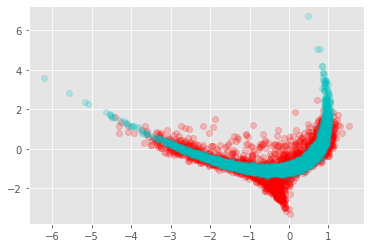

In [8]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,3],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 1], forward_pass[:, 2], 'ro', alpha=.2)
plt.plot(target_3d[:,1], target_3d[:,2], 'co', alpha = .2)

## Sampling $p(x|y)$ using triangular structure

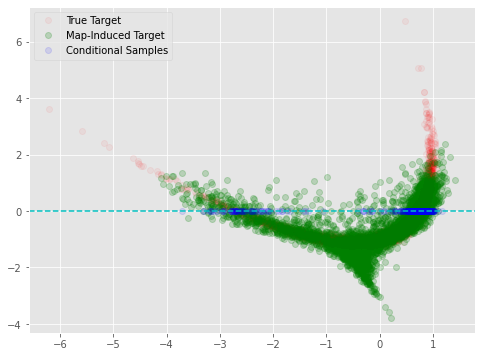

In [31]:
# We want to draw condition samples from about y = y^*
y_star = 0.0

ref_samps = tf.random.normal([5000,3],mean=0.0,stddev=1.0)
tgt_samps = nvp(ref_samps)

# Figure out what the value of r1 is
tgt_test = tf.concat([y_star*tf.ones([1,1]), tgt_samps[0:1,1:]], axis=1)
r1 = nvp.inverse(tgt_test)
r1 = float(r1[0,0])

# Now generate samples using the normalizing flow and fixed value of r1
cond_ref_samps = tf.concat([r1*tf.ones([500,1]), tf.random.normal([500,2],mean=0.0,stddev=1.0)], axis=1)
cond_tgt_samps = nvp(cond_ref_samps)

plt.figure(figsize=(8,6))
plt.plot(target_3d[:, 1], target_3d[:, 0], 'ro', alpha=.05, label='True Target')
plt.plot(tgt_samps[:, 1], tgt_samps[:, 2], 'go', alpha=.2, label='Map-Induced Target')
plt.plot(cond_tgt_samps[:, 1], cond_tgt_samps[:, 0], 'bo', alpha=.1, label='Conditional Samples')
plt.axhline(y=y_star, color='c', linestyle='--')
plt.legend(loc=2)
plt.show()

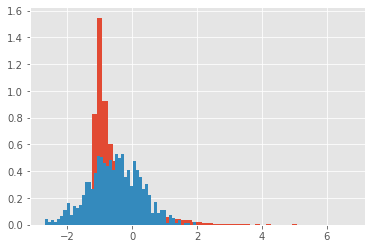

In [21]:
Ns = 1000
z = tf.random.normal([Ns,3])
X1 = nvp(z)[:,0]
plt.hist(target_2d[:,1],bins=50,density=True)
plt.hist(X1,bins=50,density=True);

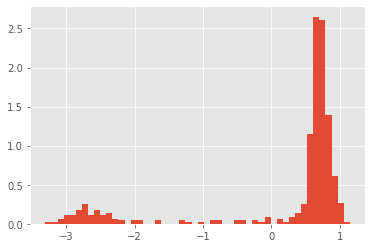

In [28]:
Ns = 1000
plt.hist(cond_tgt_samps[:, 1],bins=50,density=True);